Code to build a basic soil water budget model based on the mathematical equations used by IDC with simplification as here the key is identifying percolation rather than applied water.

In [43]:
# standard python utilities
import os
from os.path import join, exists, dirname, basename
import glob
import sys
import time

import pandas as pd
import numpy as np

import h5py

# standard python plotting utilities
import matplotlib as mpl
import matplotlib.pyplot as plt

# standard geospatial python utilities
import shapely
import geopandas as gpd



In [44]:
doc_dir = os.getcwd()
while os.path.basename(doc_dir) != 'Documents':
    doc_dir = os.path.dirname(doc_dir)
# dir of all gwfm data
gwfm_dir = os.path.dirname(doc_dir)+'/Box/research_cosumnes/GWFlowModel'
gwfm_dir
dis_dir = join(gwfm_dir, 'DIS_data')
uzf_dir = join(gwfm_dir,'UZF_data')

In [45]:
grid_uzf = gpd.read_file(uzf_dir+'/final_grid_uzf/griduzf.shp')

In [46]:
dem_data = np.loadtxt(gwfm_dir+'/DIS_data/dem_52_9_200m_mean.tsv')


In [47]:
nrow,ncol = (100, 230)

In [48]:
# slope doesn't provide clear guidance on differentiating foothills
slope_gdf = gpd.read_file(join(gwfm_dir, 'DIS_data', 'grid_zonal_stats','slope_percentage_statistics.shp'))

slope = np.zeros((nrow,ncol))
slope[slope_gdf.row-1, slope_gdf.column-1] = slope_gdf['mean']


In [49]:
def fill_uzf(uzfvalues, grid_uzf):
#     temp = np.zeros((nrow,ncol))
    temp = np.full((nrow,ncol),np.nan, dtype = uzfvalues.dtype)
    temp[grid_uzf.row.values-1,grid_uzf.column.values-1] = uzfvalues
    return(temp)

In [50]:
soil_dir = join(uzf_dir, 'final_soil_arrays')
soil_Ks_Rep = np.loadtxt(soil_dir+'/final_soilKs.tsv', delimiter = '\t')
soil_por = np.loadtxt(soil_dir+'/final_soiln.tsv', delimiter = '\t')/100
soil_eps = np.loadtxt(soil_dir+'/final_soileps.tsv', delimiter = '\t')


In [51]:
soil_Ks_Low = fill_uzf(grid_uzf.Ksat_Low, grid_uzf)
# when soil_K_low is missing using a substitute of Ksat/10
soil_Ks = np.where(soil_Ks_Low==0, soil_Ks_Rep/10, soil_Ks_Low)


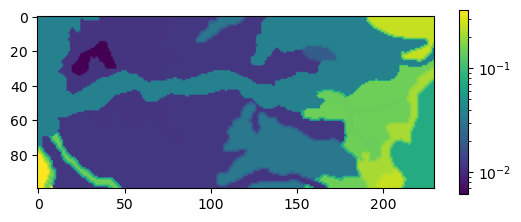

In [52]:
plt.imshow(soil_Ks, norm = mpl.colors.LogNorm())
plt.colorbar(shrink=0.5)

The soil Curve number array doesn't account for slope so we need to account for this by scaling by elevation or slope. Elevation covers the foothills, but slope more realistically is what controls lower infiltration areas.  

Based on HOB output the wells that match the recharge pulse the best are those in the floodplain which should only rebound due to floodplain inundation and the fact that they match shows that the soil water budget is overestimating recharge. Need to reduce recharge across the domain
- the soil low conductivity is generally 10 to 20 times lower than the representative value, except reducing the conductivity only reduced the grid sum, time averaged recharge by 10%.

It seems that recharge is not as greatly impacted by conductivity as I thought. 

In [53]:
# newly created 4/6/2023 to tamp down overestimates of recharge in foothills
soilCN_arr = np.loadtxt(join(soil_dir, 'final_soil_CN.csv'),  delimiter=',')
# temporary fix, CN can never be zero
soilCN_arr = np.where(soilCN_arr==0, soilCN_arr[soilCN_arr>0].min(), soilCN_arr)
# adding this extra scaling didn't significantly change the spatial distribution in wet years
# adjust CN so that the foothills have more runoff, 56m is same cutoff as in model for deep geology
# soilCN_arr[dem_data>56] = 89 # max value of curve numbers
soilCN_arr[slope>3] = 89 # max value of curve numbers

In [54]:
soilRC_arr = np.loadtxt(join(soil_dir, 'final_soil_runoff_coeff.csv'),  delimiter=',')
# temporary fix, CN can never be zero
soilRC_arr = np.where(soilRC_arr==0, soilRC_arr[soilRC_arr>0].min(), soilRC_arr)

In [55]:
irr_eff = np.loadtxt(join(soil_dir, 'static_irrigation_efficiency.csv'), delimiter=',')
# convert irrigation efficiencies to a multiplier where if no crop exists the irrigation is 0
eff_mult = 1/np.ma.masked_where(irr_eff==0, irr_eff, )
eff_mult[irr_eff==0] = 0
eff_mult = eff_mult.data

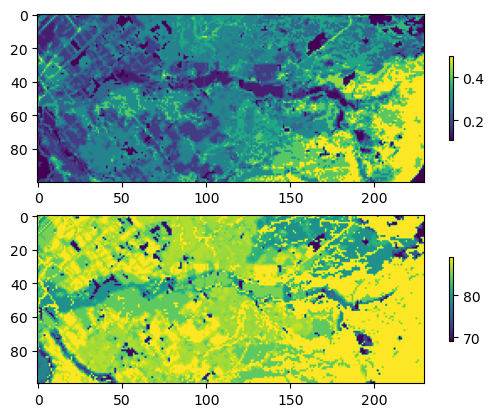

In [56]:
fig,ax=plt.subplots(2,1)
# I could add runoff coefficients to further reduce infiltration in the foothills
im=ax[0].imshow(soilRC_arr)
plt.colorbar(im,shrink=0.5)

im=ax[1].imshow(soilCN_arr)
plt.colorbar(im,shrink=0.5)

The curve number is dominantly influenced by land use and hydrologic condition. The runoff coefficient includes more influence from slope which is necessary in the model to reduce excess recharge in the foothills. I could apply the runoff coefficients to the rainfall before applying to the SCS-CN method.

Rather than apply runoff coefficients, I updated the CN input to choose Hydrologic Condition based on slope. Slope >3% was pooor and <3% was fair.

In [57]:
# strt_date = pd.to_datetime('2014-10-1')
strt_date = pd.to_datetime('1998-10-1')
end_date = pd.to_datetime('2020-9-30')
dates = pd.date_range(strt_date, end_date)

nrow, ncol = (100,230)

In [58]:
nrow_p,ncol_p = (100,230)
def dwr_etc(strt_date, end_date):
    nper_tr = (end_date-strt_date).days+1
    natETc = np.zeros((nper_tr,nrow_p,ncol_p))
    agETc = np.zeros((nper_tr,nrow_p,ncol_p))

    per_n = 0 
    for y in np.arange(strt_date.year, end_date.year+1):
        # set start and end date for range for the year to be iterated over
        yr_strt = pd.to_datetime(str(y)+'-01-01')
        yr_end = pd.to_datetime(str(y)+'-12-31')
        # get the length of the date range needed for that year
        yearlen = len(pd.date_range(yr_strt, yr_end))
        if yr_strt < strt_date:
            yr_strt = strt_date
        if yr_end > end_date:
            yr_end = end_date
        yr_len = len(pd.date_range(yr_strt, yr_end))
        # load hdf5 files
        f_irr = h5py.File(join(uzf_dir, "dwr_ETc/irrigated_"+str(y)+".hdf5"), "r")
        agETc[per_n:per_n+yr_len,:,:] = f_irr['array'][str(y)][:][yr_strt.dayofyear-1:yr_end.dayofyear,:,:]
        f_irr.close()
        f_nat = h5py.File(join(uzf_dir, "dwr_ETc/native_"+str(y)+".hdf5"), "r")
        natETc[per_n:per_n+yr_len,:,:] = f_nat['array'][str(y)][:][yr_strt.dayofyear-1:yr_end.dayofyear,:,:]
        f_nat.close()
        per_n += yr_len
    # make sure the return value is separate from the loop
    return(agETc, natETc)

Part of the issue with evapotranspiratoin is that in the foothills there are spots with no ET so there is nothing to use up water in the soil zone, thus all the water percolates especially in areas of thicker soil.
- One solution in the foothills would be to fill in the spots based on nearby data as I know there has to be some evapotranspiration

In [59]:
agETc, natETc = dwr_etc(strt_date, end_date)
# net ETc should be ETc from ag and native plants joined
ETc_in = agETc + natETc

# reference for cells with agriculture which have slightly different rules
ag_arr = agETc.sum(axis=0)>0


In [60]:
ETc = np.copy(ETc_in)
# fill in the et in missing spots with the median ET in the foothill
# usually 56 m is set for foothills, 50 m includes a slightly larger area
for t in np.arange(0, len(ETc)):
    ETc[t, dem_data>50] = np.median(ETc_in[t, dem_data>50])

In [61]:
# plt.imshow(dem_data>50)

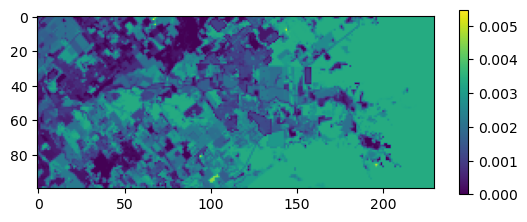

In [62]:
plt.imshow(ETc.mean(axis=0))
plt.colorbar(shrink=0.5)

In [63]:
## Potential ETo spatial interpolation from CIMIS
fn = glob.glob(join(uzf_dir,'CIMIS','Cosumnes_dailyET_precip*.csv'))
daily_data = pd.DataFrame()
for file in fn:
    new_data = pd.read_csv(file, index_col = ['Date'], parse_dates = True)
    daily_data = pd.concat((daily_data, new_data))
# units of mm
data_in = daily_data[daily_data['Stn Name']=='Fair Oaks']
# clean up data so columns are by location, units of Precip are in mm
rain_in = data_in.pivot_table(index = 'Date', columns = 'Stn Name', values = 'Precip (mm)')
rain_m = rain_in/1000

# create array for every period of rainfall
rain_df = rain_m[strt_date:end_date].resample('D').interpolate('linear')['Fair Oaks']
rain_arr = np.repeat(np.repeat(np.reshape(rain_df.values, (rain_df.shape[0],1,1)), nrow, axis=1),ncol, axis=2)


In [64]:
# load in pre-processed array of ETc for all time
ETc_long = pd.read_hdf(join(uzf_dir, "dwr_ETc",'long_ETc_all_lu.hdf5'), key='variable')
# convert to column format
ETc_all = ETc_long.pivot(columns='variable', values='value')

# subset for model period
ETc_all = ETc_all[strt_date:end_date]
# fill in empty dates with interpolation (temporary since corn dates are slightly different)
ETc_all = ETc_all.reindex(dates)


If we need to remove ET from each step then we should reduce the number of crops used to simplify calculations unless the code runs quickly for all cells.
- Need to assume initial water content of 0. 
 
* water content can't exceed porosity. It is assumed that θ can be computed to be greater than θT, and the difference between the θ and θT represents the depth of the pond.

Soil water budget equation simplified.  
$ \theta^{t+1} Z^{t+1} = \theta^{t} Z^{t} + \Delta t(P^{t+1} - R_p^{t+1} - P_c^{t+1} - ET^{t+1}) $  
where P = precip, Rp = runoff, P_c = percolation and ET = evapotranspiration  

Percolation equation from IDC per Mualem and van Genuchten.  
$ P_{C}^{t+1} = K_{s} (\frac{\theta^{t+1}}{\theta_T})[1 -(1-(\frac{\theta^{t+1}}{\theta_T})^{1/m})^m]^2 $  
Could convert to the explicit form, by using water content from the previous period.

Runoff based on SCS-CN method  
$ R_p = \frac{1}{\Delta t}\frac{(P\Delta t-0.2S)^2}{P\Delta t+0.8S}$  
$ S = S_{max} (1- \frac{\theta^t - \theta_f/2}{\theta_T - \theta_f/2}) $ when $\theta^t >\theta_f/2 $  
$ S = S_{max}  $ when $\theta^t <\theta_f/2 $  
$ S_{max} = \frac{1000}{CN} - 10 $  
S  is the potential maximum soil retention in inches.  
IDC manual didn't specify this, but per the HEC-HMS guide on CNs the runoff is 0 when precipitation is less than initial abstraction which is assigned as $I_a = rS$  where $0.05 < r <0.2$

In [65]:
soildepth = fill_uzf(grid_uzf.SoilDepth, grid_uzf)
psdi =  fill_uzf(grid_uzf.PSDI, grid_uzf)
# parameter for Mualem, van Genuchten
soil_m = psdi/(psdi+1)
wc_f =  fill_uzf(grid_uzf.w3rdbar, grid_uzf)/100 #field capacity
wc_wp =  fill_uzf(grid_uzf.w15bar, grid_uzf)/100 # wilting point

# for runoff, convert CN from fraction to CN
Smax = (1000/soilCN_arr) - 10

In [66]:
# plt.imshow(soilCN_arr)
# plt.colorbar(shrink=0.5)
# plt.show()
# plt.imshow(soil_Ks)
# plt.colorbar(shrink=0.5)
# plt.show()
# plt.imshow(slope>3)
# plt.colorbar(shrink=0.5)

In [67]:
def calc_S(wc, Smax, wc_f, soil_por):
    """ Given an array of water contents return potential soil retention"""
    S = np.zeros((nrow,ncol))
    # when water content is less than 1/2 field capacity, full retention
    S[wc < wc_f/2] = Smax[wc < wc_f/2]
    # wc > porosity then set as porosity for calculations (avoids S >1)
    wc_calc = np.where(wc<soil_por, wc, soil_por)
    # when water content is greater than 1/2 field capacity, partial retention 
    S1 = Smax * (1 - ((wc_calc - wc_f/2)/(soil_por - wc_f/2)))
    S[wc >= wc_f/2]= S1[wc >= wc_f/2]
    # convert S from inches to meters
    S *= (0.3048/12)
    return(S)

In [68]:
# create an array of ETo values to surve as a proxy for bare soil ET
# may need to add scaling factor, but this avoids excess infiltration in winter
ETb_vals = ETc_all['Fair Oaks'].values
ETb = np.repeat(np.repeat(np.reshape(ETb_vals, (len(ETb_vals), 1, 1)), ETc.shape[1], axis=1), ETc.shape[2], axis=2)
# where there is already crop ET, remove the extra ET
ETb[ETc !=0] = 0

# Run the model

In [69]:
tic = time.time()
nper = (end_date-strt_date).days +1
wc = np.zeros((nper+1, nrow, ncol)) # water content, add initial conditions with +1
pc = np.zeros((nper, nrow, ncol)) # percolation
rp = np.zeros((nper, nrow, ncol)) # runoff 
ETa = np.zeros((nper, nrow, ncol)) # actual ET
AW = np.zeros((nper, nrow, ncol)) # applied water
wb_sum= np.zeros((nper, nrow, ncol)) # water budget check
# time units are days for everything

# WC starts at field content for ag fields and wilting point for non ag
wc[0] = wc_wp
wc[0, ag_arr] = wc_f[ag_arr]
# -1 starts at IC
#     n is for BC, ns is for storage
for ns, n in enumerate(np.arange(-1, nper-1)):
# for n in np.arange(-1, nper-1):
    # calculate soil saturation as water content can be greater than porosity assuming it represents ponding
    sat = wc[ns]/soil_por
    sat  = np.where(sat>1, 1, sat)
    ## Runoff ##
    S = calc_S(wc[ns], Smax, wc_f, soil_por)
    # calculate runoff only when there is rain, and rain is uniform
    if (rain_arr[n+1]>0).any():
        rp[n+1] = ((rain_arr[n+1] - 0.2*S)**2)/(rain_arr[n+1] + 0.8*S)
    # where rainfall is less than initial abstraction (0.2S) set runoff as 0
    rp[n+1] = np.where(rain_arr[n+1]<0.2*S, 0, rp[n+1])
    ## explicit percolation ##
    pc[n+1] = soil_Ks*(sat)*(1- (1-(sat)**(1/soil_m))**soil_m)**2
    # water budget - all at once would require iteration
#     wc[ns+1] = (wc[ns]*soildepth + (rain_arr[n+1] - rp[n+1] - pc[n+1] - ETc[n+1]))/soildepth
#     wc[ns+1] = np.where(wc[ns+1]<0,0,wc[ns+1])
    # stepwise water budget, explicit to avoid iteration
    # take away runoff first
    wc[ns+1] = (wc[ns]*soildepth + (rain_arr[n+1] - rp[n+1]))/soildepth
    # add irrigation with the assumption it is designed to limit runoff
    AW[n+1] = agETc[n+1]*eff_mult
#     AW[n+1] = 0
    wc[ns+1] = wc[ns+1] + AW[n+1]/soildepth
    # take away ET, add term to prevent going to zero
    ET = ETc[n+1] #+ ETb[n+1] # ET will be from crops or bare soil (off season)
    ETa[n+1] = np.where(ET <= wc[ns+1]*soildepth, ET, wc[ns+1]*soildepth - 1E-9)
    # take away ET, add term to prevent going to zero
#     ETa[n+1] = np.where(ETc[n+1] <= wc[ns+1]*soildepth, ETc[n+1], wc[ns+1]*soildepth - 1E-9)
    wc[ns+1] = wc[ns+1] + (-ETa[n+1])/soildepth
    # take away percolation
    pc[n+1] = np.where(pc[n+1] <= wc[ns+1]*soildepth, pc[n+1], wc[ns+1]*soildepth - 1E-9)
    wc[ns+1] = wc[ns+1] + (-pc[n+1])/soildepth
    # check water budget error
    wb_sum[n+1] = (wc[ns]-wc[ns+1])*soildepth + rain_arr[n+1] + AW[n+1] - rp[n+1] - ETa[n+1] - pc[n+1]
    if (wb_sum[n+1]>1E-3).any()|(wb_sum[n+1]<-1E-3).any():
        print('WB error exceeds 1E-3',n )
toc = time.time()
print('Run time was %.2f minutes' %((toc-tic)/60))
print('Avg WB error was %.2E m' % wb_sum.sum(axis=(1,2)).mean())

Run time was 0.27 minutes
Avg WB error was 1.70E-14 m


In [70]:
# plt.plot(ETb.mean(axis=(1,2)))

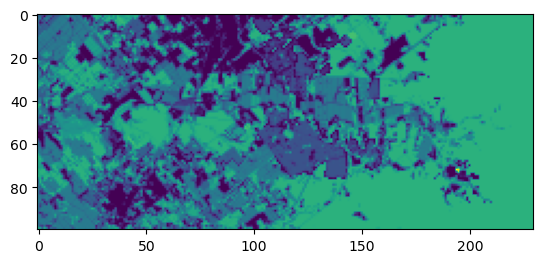

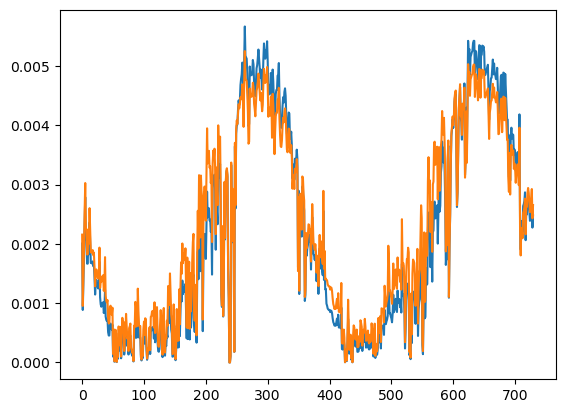

In [71]:
last2 = ETc[-365*2:]
# last2 = AW[-720:]
plt.imshow(last2.mean(axis=0))
plt.show()
last2_ts = last2[:, 40:80,10:40].mean(axis=(1,2))
plt.plot(last2_ts)
last2_ts = last2[:, :,:].mean(axis=(1,2))
plt.plot(last2_ts)

In [29]:
# n = 32
# chk = -(wc[n] - wc[n-1])*soildepth + rain_arr[n] - rp[n] - ETa[n] - pc[n]
# chk.max()
# (wc[n] - wc[n-1])*soildepth

In [30]:
# n=14
# S = calc_S(wc[n], Smax, wc_f, soil_por)
# rp = ((rain_arr[n] - 0.2*S)**2)/(rain_arr[n] + 0.8*S)



In [31]:
# plt.imshow(np.nanmean(ETb, axis=0))
# plt.colorbar(shrink=0.5)

In [32]:
# # plt.plot(ETc.mean(axis=(1,2)))
# # plt.plot(ETb.mean(axis=(1,2)))

# plt.plot(agETc.mean(axis=(1,2)), label='agETc')
# plt.plot(ETb[:,ag_arr].mean(axis=(1)), label='ag ETb', alpha=0.6)

# plt.legend()

The summed irrigation is less than ETc because not all of the land is irrigated. 

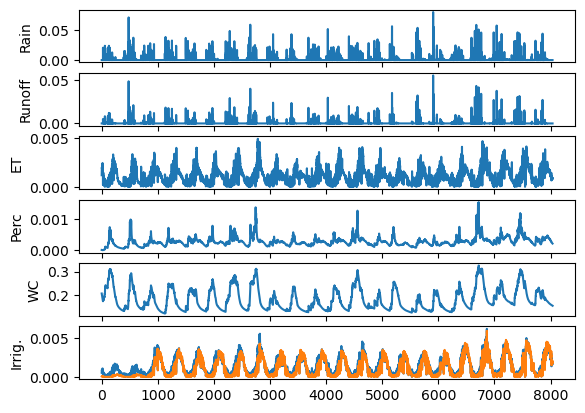

In [72]:
fig,ax = plt.subplots(6,1,sharex=True)
ax[0].plot(rain_arr.mean(axis=(1,2)))
ax[1].plot(rp.mean(axis=(1,2)))
ax[2].plot(ETa.mean(axis=(1,2)))
ax[3].plot(pc.mean(axis=(1,2)))
ax[4].plot(wc.mean(axis=(1,2)))
# plot irrigation and applied water for ag lands only
ax[5].plot(ETa[:,ag_arr].mean(axis=(1)))
ax[5].plot(AW[:,ag_arr].mean(axis=(1)))

for n, l in enumerate(['Rain','Runoff','ET','Perc','WC', 'Irrig.']):
    ax[n].set_ylabel(l)

In [68]:
pc_noirr = pc.copy()

## Save Output

In [73]:

import h5py

def arr_to_h5(arr, h5_fn):
    # convert arrays of annual rates to hdf5 files individually
    with h5py.File(h5_fn, "w") as f:
        grp = f.require_group('array') # makes sure group exists
        grp.attrs['units'] = 'meters/day'
        grp.attrs['description'] = 'Each layer of the array is a day in the water year'
        dset = grp.require_dataset('WY', arr.shape, dtype='f', compression="gzip", compression_opts=4)
        dset[:] = arr
    


In [74]:
# years and array index 
# include final year for specifying index then drop
years = pd.date_range(strt_date,end_date+pd.DateOffset(years=1),freq='AS-Oct')
yr_ind = (years-strt_date).days
years = years[:-1]

In [75]:

# need separte hdf5 for each year because total is 300MB
# for n in np.arange(len(years)-1,len(years)):
for n in np.arange(0,len(years)):
    # deep percolation
    arr = pc[yr_ind[n]:yr_ind[n+1]]
    fn = join(uzf_dir, 'basic_soil_budget',"percolation_WY"+str(years[n].year+1)+".hdf5")
    arr_to_h5(arr, fn)
    # applied water 
    arr = AW[yr_ind[n]:yr_ind[n+1]]
    fn = join(uzf_dir, 'basic_soil_budget',"applied_water_WY"+str(years[n].year+1)+".hdf5")
    arr_to_h5(arr, fn)

## Review precip vs percolation

In [45]:
chk = pc.sum(axis=(1,2))*200*200/((0.3048**3)*43560)
chk1 = rain_arr.sum(axis=(1,2))*200*200/((0.3048**3)*43560)

for n in np.arange(0,len(yr_ind)-1):
    print('Perc %.2e'%(chk[yr_ind[n]:yr_ind[n+1]]).sum(), end=', ')
    print('Rain %.2E' %(chk1[yr_ind[n]:yr_ind[n+1]].sum()), end=', ')
    print('Frac %.2f'%(chk[yr_ind[n]:yr_ind[n+1]].sum()/chk1[yr_ind[n]:yr_ind[n+1]].sum()))


Perc 2.70e+04, Rain 3.39E+05, Frac 0.08
Perc 1.60e+05, Rain 4.83E+05, Frac 0.33
Perc 9.60e+04, Rain 3.07E+05, Frac 0.31
Perc 7.89e+04, Rain 3.71E+05, Frac 0.21
Perc 7.65e+04, Rain 3.59E+05, Frac 0.21
Perc 7.56e+04, Rain 3.07E+05, Frac 0.25
Perc 1.30e+05, Rain 4.87E+05, Frac 0.27
Perc 1.64e+05, Rain 5.08E+05, Frac 0.32
Perc 4.96e+04, Rain 2.62E+05, Frac 0.19
Perc 5.08e+04, Rain 2.40E+05, Frac 0.21
Perc 5.69e+04, Rain 3.12E+05, Frac 0.18
Perc 7.73e+04, Rain 3.58E+05, Frac 0.22
Perc 1.58e+05, Rain 5.38E+05, Frac 0.29
Perc 6.39e+04, Rain 3.13E+05, Frac 0.20
Perc 6.77e+04, Rain 2.94E+05, Frac 0.23
Perc 4.37e+04, Rain 2.92E+05, Frac 0.15
Perc 5.19e+04, Rain 2.87E+05, Frac 0.18
Perc 6.59e+04, Rain 3.25E+05, Frac 0.20
Perc 2.22e+05, Rain 7.01E+05, Frac 0.32
Perc 8.53e+04, Rain 4.50E+05, Frac 0.19
Perc 1.62e+05, Rain 5.76E+05, Frac 0.28
Perc 5.36e+04, Rain 3.01E+05, Frac 0.18


The addition of irrigation with extra to account for efficiency losses led to 2-3 times more deep percolation

In [73]:
# comparing effect of adding irrigation with efficiency values
for n in np.arange(0,len(yr_ind)-1):
    pc_sum = pc[yr_ind[n]:yr_ind[n+1]].sum()
    pc_noirr_sum = pc_noirr[yr_ind[n]:yr_ind[n+1]].sum()
    print('Perc frac increase %.2f'%(pc_sum/pc_noirr_sum), end=', ')
    
    etc_sum = agETc[yr_ind[n]:yr_ind[n+1]].sum()
    etc_irr_sum = AW[yr_ind[n]:yr_ind[n+1]].sum()
    print('ETc %.2f'%(etc_irr_sum/etc_sum))

Perc frac increase 1.03, ETc 1.15
Perc frac increase 1.05, ETc 1.15
Perc frac increase 1.37, ETc 1.11
Perc frac increase 1.82, ETc 1.11
Perc frac increase 1.81, ETc 1.11
Perc frac increase 1.78, ETc 1.11
Perc frac increase 1.57, ETc 1.11
Perc frac increase 1.42, ETc 1.11
Perc frac increase 2.03, ETc 1.11
Perc frac increase 2.02, ETc 1.11
Perc frac increase 2.08, ETc 1.11
Perc frac increase 1.76, ETc 1.11
Perc frac increase 1.47, ETc 1.11
Perc frac increase 1.85, ETc 1.11
Perc frac increase 1.79, ETc 1.11
Perc frac increase 2.38, ETc 1.10
Perc frac increase 2.09, ETc 1.11
Perc frac increase 2.03, ETc 1.27
Perc frac increase 1.44, ETc 1.28
Perc frac increase 1.90, ETc 1.27
Perc frac increase 1.53, ETc 1.27
Perc frac increase 2.08, ETc 1.28
